In [1]:

import pandas as pd
import numpy as np
from scipy import stats
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import QuantileTransformer

import xgboost
from xgboost import XGBRegressor    
from xgboost import XGBRegressor as model

def count1(df):
    result=[]
    index=df.index.tolist()
    for i in index:
        x=df.loc[i].sum()
        result.append(x-1)
    return result

def vcl_tr(df):
    df_=df.loc[:, 'VCL1':'VCL16']
    result=[]
    index=df_.index.tolist()
    for i in index:
        x=df_.loc[i].sum()
        if(x>=9):
            result.append(1)
        else:
            result.append(0)
    train['VCL_M']=result
    
def vcl_te(df):
    df_=df.loc[:, 'VCL1':'VCL16']
    result=[]
    index=df_.index.tolist()
    for i in index:
        x=df_.loc[i].sum()
        if(x>=9):
            result.append(1)
        else:
            result.append(0)
    test['VCL_M']=result

def count0(df):
    result=[]
    index=df.index.tolist()
    for i in index:
        x=df.loc[i].sum()
        result.append(x-1)
    return result


def q_tr(df):
    df_=df.loc[:, 'Q1':'Q26']
    result=[]
    index=df_.index.tolist()
    for i in index:
        x=df_.loc[i].tolist()
        re=0
        for j in x:
            re+=((j-1)/4)*100
        result.append(re/(len(x)-1))
    train['Q_m']=result
    
def q_te(df):
    df_=df.loc[:, 'Q1':'Q26']
    result=[]
    index=df_.index.tolist()
    for i in index:
        x=df_.loc[i].tolist()
        re=0
        for j in x:
            re+=((j-1)/4)*100
        result.append(re/(len(x)-1))
    test['Q_m']=result
    
def question_nan(df,col):
    print(col)
    train_q0=df[df[col]==0.0]
    train_q1=df[df[col]!=0.0]
    test_=train_q0
    #결과 없는 test
    train_=train_q1
    #결과 들어가있는 train
    test_=test_.drop(col,axis=1)
    y = train_[col]
    x= train_.drop(col,axis =1)
    model = XGBRegressor(objective='reg:squarederror',learning_rate=0.1,max_depth = 4, n_estimators = 1000,n_jobs=-1)
    model.fit(x, y)
    pred = model.predict(test_)      
    pred=pred.round(0)
    pred=pred.tolist()
    for i in range(len(pred)):
        if(pred[i]<=0):
            pred[i]=1
    index=test_.index.tolist()
    for i in range(len(index)):
        df.at[index[i],col]=pred[i]
        

def age_outlier(df):
    mean=int(df['age'].mean())
    index=df[df['age']>110].index

    for i in index:
        df.at[i,'age']=mean


def family_outlier(df):
    mean=int(df['familysize'].mean())
    index=df[df['familysize']>100].index
    for i in index:
        df.at[i,'familysize']=mean




In [2]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
Question_te=test.loc[:, 'Q1':'Q26']


In [3]:
country_map = {}

for i, c in enumerate(train['country'].unique()):
    country_map[c] = i
    


# train feature

In [4]:

train['country'] = train['country'].map(country_map)
train = train.fillna(0)#test 결측치 0으로 채우기
train=train.drop(train.loc[:,'VCL1':'VCL16'],axis=1)
age_outlier(train)
family_outlier(train)


# test feature

In [5]:

test['country'] = test['country'].map(country_map) #country열 Mapping
test = test.fillna(0)
test=test.drop(test.loc[:,'VCL1':'VCL16'],axis=1)
age_outlier(test)
family_outlier(test)

In [6]:
#vcl_tr(train)
#vcl_te(test)
#q_tr(train)
#q_te(test)


In [7]:
'''

col=Question_te.columns.tolist()
col

for i in col:
    question_nan(train,i)
    
for i in col:
    question_nan(test,i)
'''
'\n\ncol=Question_te.columns.tolist()\ncol\n\nfor i in col:\n    question_nan(train,i)\n    \nfor i in col:\n    question_nan(test,i)\n'


'\n\ncol=Question_te.columns.tolist()\ncol\n\nfor i in col:\n    question_nan(train,i)\n    \nfor i in col:\n    question_nan(test,i)\n'

In [8]:
train=train.drop('index',axis=1)
test=test.drop('index',axis=1)

In [9]:
from sklearn.preprocessing import RobustScaler


promos = ['introelapse','testelapse','surveyelapse']
#MinMaxScaler
#StandardScaler
#RobustScaler
#QuantileTransformer
#PowerTransformer
#KBinsDiscretizer
scaler = QuantileTransformer()
scaler.fit(train[promos])
train[promos] = scaler.transform(train[promos])
test[promos] = scaler.transform(test[promos])



In [10]:
x_train = train.drop('nerdiness',axis=1)
#x_train=x_train.loc[:, 'Q1':'Q26']
y_train = train['nerdiness']



In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, n_jobs=-1)


from sklearn.model_selection import KFold, GridSearchCV #하이퍼파라미터 튜닝을 위한 불러오기
from sklearn.metrics import accuracy_score

model_param_grid = {'n_estimators' : [100, 1000, 3000]} # Default(100)대비 큰값으로 Dictionary구성

model_grid = GridSearchCV(model, param_grid = model_param_grid, scoring="accuracy",n_jobs=-1,verbose=1) #훈련 (장치 사양에 따라 시간이 걸릴 수 있음)
model_grid.fit(x_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1, param_grid={'n_estimators': [100, 1000, 3000]},
             scoring='accuracy', verbose=1)

In [12]:
gcv=GridSearchCV(model, param_grid=model_param_grid, scoring='f1', n_jobs=-1)
gcv.fit(x_train.values,y_train.values)
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력



final params {'n_estimators': 1000}


In [13]:
model = RandomForestClassifier(n_estimators=3000, random_state=42, n_jobs=-1)




In [14]:
model.fit(x_train, y_train) #학습
pred = model.predict_proba(test)[:,1] #proba를 통해 확률값으로 변환
sample['nerdiness'] = pred
sample.to_csv('result8.11_4.csv',index=False)


,index,nerdiness
0,0,0.251000
1,1,0.830000
2,2,0.844000
3,3,0.605333
4,4,0.858000
...,...,...
35447,35447,0.864667
35448,35448,0.724333
35449,35449,0.921333
35450,35450,0.232667


In [17]:

sample['nerdiness'].sum()
#19384.0
#19228.0  result8.6_3
# 19729.191 result8.9_1
# 19737.59333333333 result8.11_2.csv   0.9026266776	
# 19722.430333333334  result8.11_3.csv   0.9021614897
#19731.831  result8.11_4


19731.831

Q1
[1. 4. 5. 3. 2. 0.]
Q2
[5. 4. 3. 2. 1. 0.]
Q3
[5. 4. 3. 2. 0. 1.]
Q4
[5. 4. 2. 3. 1. 0.]
Q5
[1. 4. 3. 5. 2. 0.]
Q6
[4. 5. 3. 2. 1. 0.]
Q7
[5. 4. 3. 2. 1. 0.]
Q8
[5. 4. 2. 3. 1. 0.]
Q9
[1. 3. 4. 5. 2. 0.]
Q10
[3. 4. 5. 2. 1. 0.]
Q11
[5. 1. 2. 4. 3. 0.]
Q12
[5. 4. 2. 3. 1. 0.]
Q13
[5. 2. 3. 1. 4. 0.]
Q14
[5. 3. 4. 2. 0. 1.]
Q15
[5. 1. 4. 3. 2. 0.]
Q16
[5. 2. 3. 1. 4. 0.]
Q17
[5. 4. 1. 2. 3. 0.]
Q18
[1. 5. 3. 2. 4. 0.]
Q19
[5. 1. 4. 3. 2. 0.]
Q20
[5. 3. 2. 4. 1. 0.]
Q21
[1. 2. 3. 4. 5. 0.]
Q22
[5. 1. 4. 2. 3. 0.]
Q23
[1. 5. 2. 3. 4. 0.]
Q24
[5. 3. 4. 1. 2. 0.]
Q25
[1. 2. 4. 3. 5. 0.]
Q26
[1. 5. 2. 4. 3. 0.]
country
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92

NameError: name 'd' is not defined

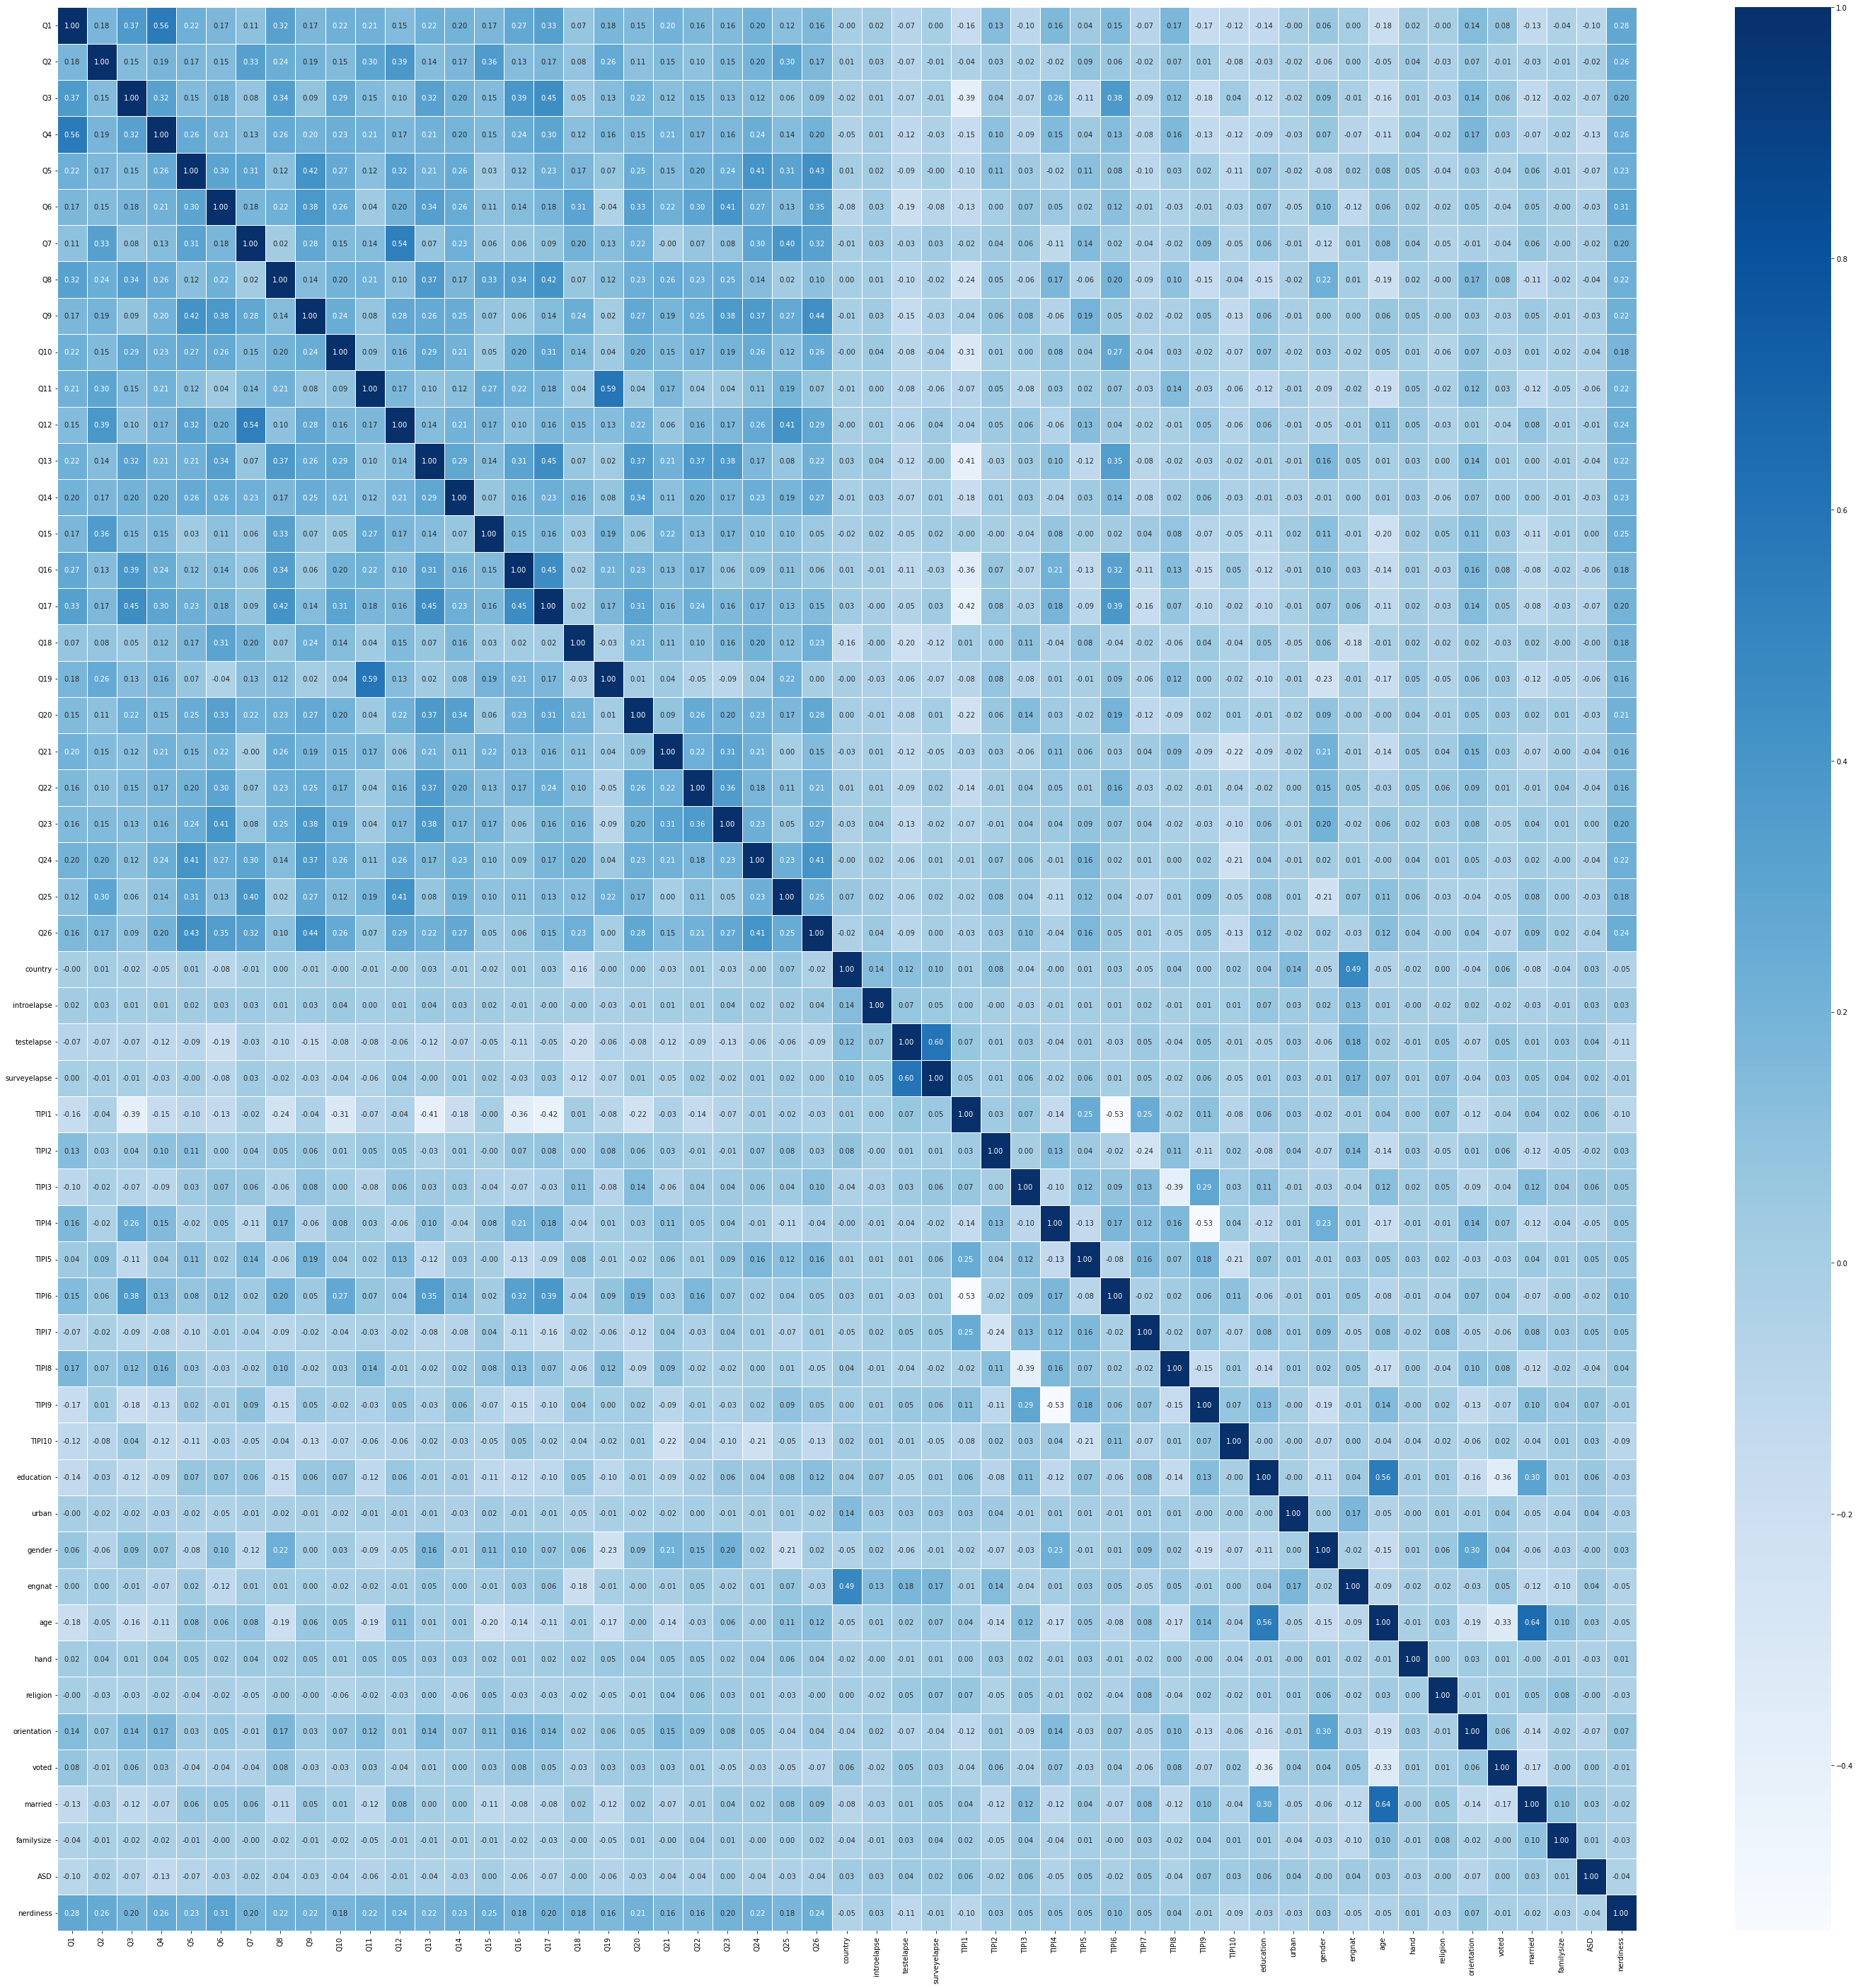

In [16]:
col=train.columns
col=col.tolist()
for i in col:
    print(i)
    print(train[i].unique())



In [ ]:
plt.figure(figsize=(50,50))
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')
 